In [2]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

# Explore Data

In [4]:
cat_directory = '../data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat


,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [7]:
row = cat.iloc[1]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1970, 3, 25, 3, 32)

In [8]:
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

np.float64(12720.0)

In [9]:
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1970-03-25HR00_evid00003'

In [15]:
data_directory = '../data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
mseed_file = f'{data_directory}{test_filename}.mseed'

In [16]:
st = read(mseed_file)
data_cat = pd.read_csv(csv_file)
data_cat


,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-03-25T00:00:00.440000,0.000000,-5.481780e-15
1,1970-03-25T00:00:00.590943,0.150943,-6.878653e-15
2,1970-03-25T00:00:00.741887,0.301887,-7.486137e-15
3,1970-03-25T00:00:00.892830,0.452830,-7.191481e-15
4,1970-03-25T00:00:01.043774,0.603774,-6.287278e-15
...,...,...,...
572406,1970-03-26T00:00:01.345660,86400.905660,8.188906e-16
572407,1970-03-26T00:00:01.496604,86401.056604,-6.852630e-17
572408,1970-03-26T00:00:01.647547,86401.207547,-8.490759e-16
572409,1970-03-26T00:00:01.798491,86401.358491,-1.930016e-15


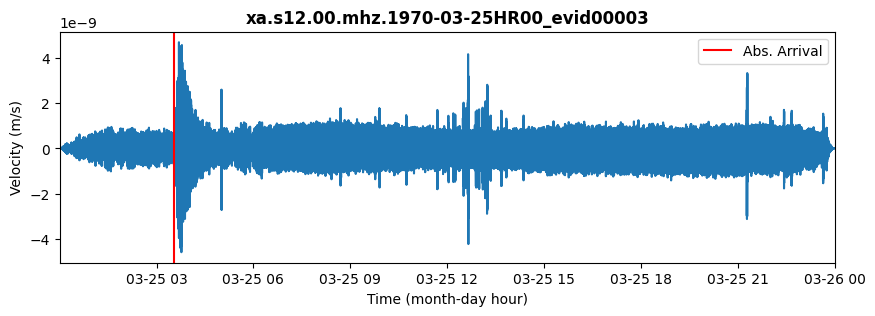

In [13]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])


## Using miniseed

In [28]:
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-03-25T00:00:00.440000Z
         endtime: 1970-03-26T00:00:01.949434Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572411
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [30]:
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

12719.56

In [34]:
minfreq = 0.1
maxfreq = 5.0
# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

d:\Projects\NASA SpaceApps\.venv\Lib\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (5.0) of bandpass is at or above Nyquist (3.3125). Applying a high-pass instead.
  warnings.warn(msg)


In [35]:
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

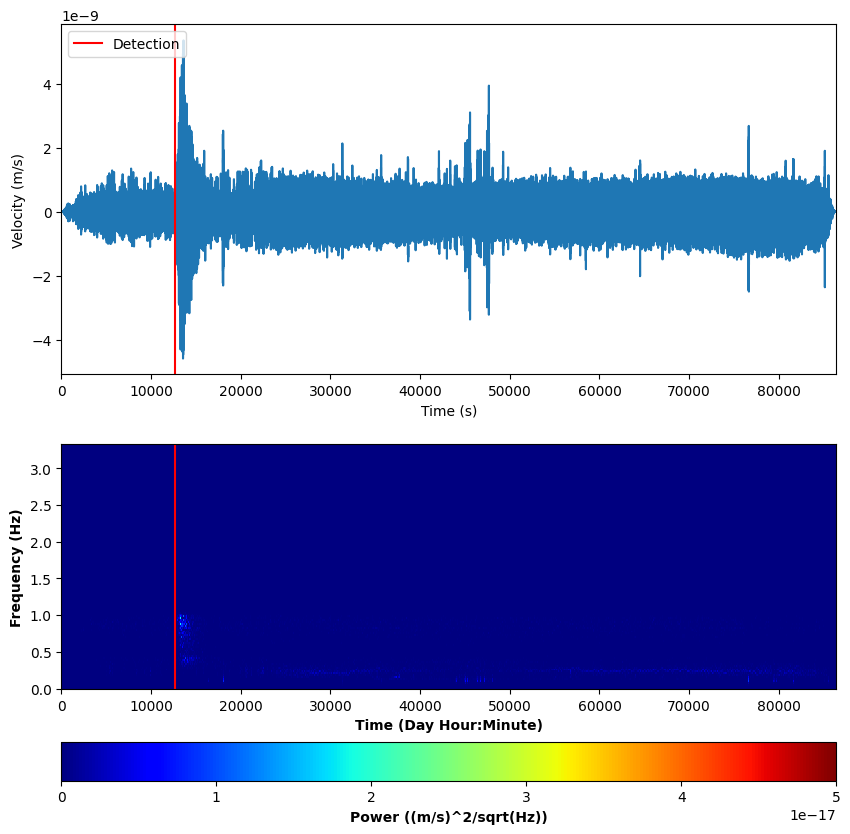

In [36]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# Analyzing seismographic for Mars

In [37]:
cat_directory = '../data/mars/training/catalogs/'
cat_file = cat_directory + 'Mars_InSight_training_catalog_final.csv'
cat = pd.read_csv(cat_file)
cat


,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:08:27.000000,507.0,evid0005
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,2022-01-02T04:35:30.000000,2130.0,evid0006


In [38]:
row = cat.iloc[1]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(2022, 1, 2, 4, 35, 30)

In [39]:
test_filename = row.filename
test_filename

'XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv'

In [51]:
data_directory = r'../data/mars/training/data/'
csv_file = f'{data_directory}{test_filename}'
mseed_file = f'{data_directory}{test_filename.split(".csv")[0]}.mseed'

In [52]:
data_cat = pd.read_csv(csv_file)
st = read(mseed_file)
data_cat

,time(%Y-%m-%dT%H:%M:%S.%f),rel_time(sec),velocity(c/s)
0,2022-01-02T04:00:00.025000,0.00,0.000000
1,2022-01-02T04:00:00.075000,0.05,0.000503
2,2022-01-02T04:00:00.125000,0.10,0.003635
3,2022-01-02T04:00:00.175000,0.15,0.010198
4,2022-01-02T04:00:00.225000,0.20,0.028214
...,...,...,...
71995,2022-01-02T04:59:59.775000,3599.75,0.010700
71996,2022-01-02T04:59:59.825000,3599.80,0.006193
71997,2022-01-02T04:59:59.875000,3599.85,0.002047
71998,2022-01-02T04:59:59.925000,3599.90,0.000555


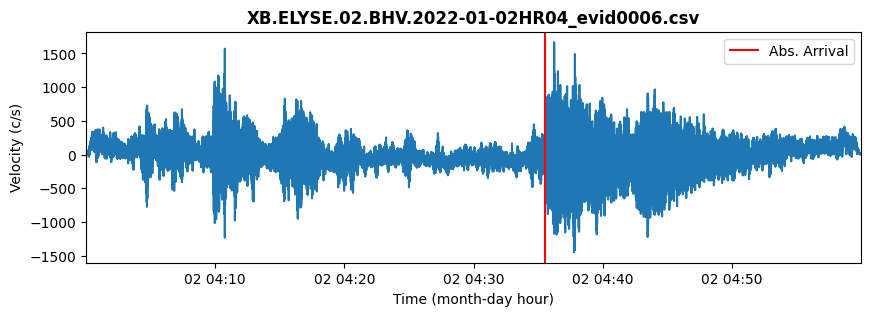

In [54]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(c/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (c/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])


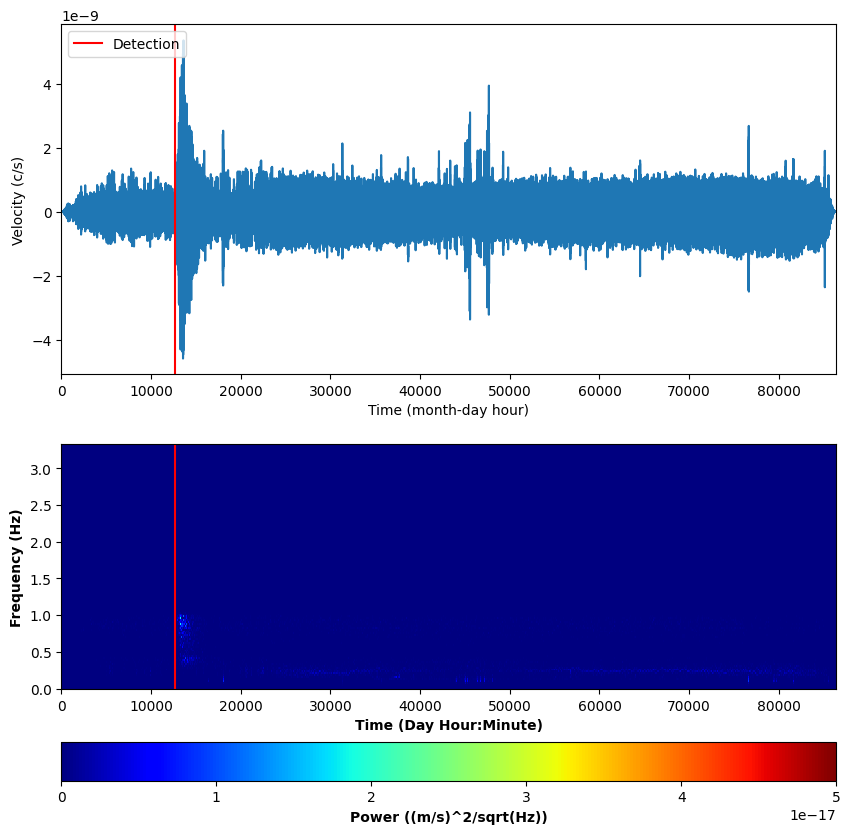

In [57]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (c/s)')
ax.set_xlabel('Time (month-day hour)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

In [59]:
print(st[0].stats)

         network: XB
         station: ELYSE
        location: 02
         channel: BHV
       starttime: 2022-01-02T04:00:00.025000Z
         endtime: 2022-01-02T04:59:59.975000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 72000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 143, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 585728})


In [60]:
print(type(st[0].stats.starttime))  # <class 'obspy.core.utcdatetime.UTCDateTime'>
print(type(st[0].stats.sampling_rate))  # <class 'float'>

<class 'obspy.core.utcdatetime.UTCDateTime'>
<class 'float'>


In [61]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

Text(0, 0.5, 'Characteristic function')

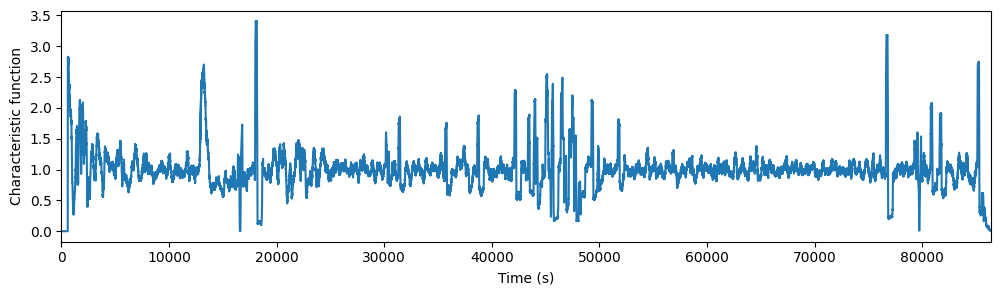

In [65]:
df = tr.stats.sampling_rate
# How long should the short-term and long-term window be, in seconds?
sta_len = 160
lta_len = 600
# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')


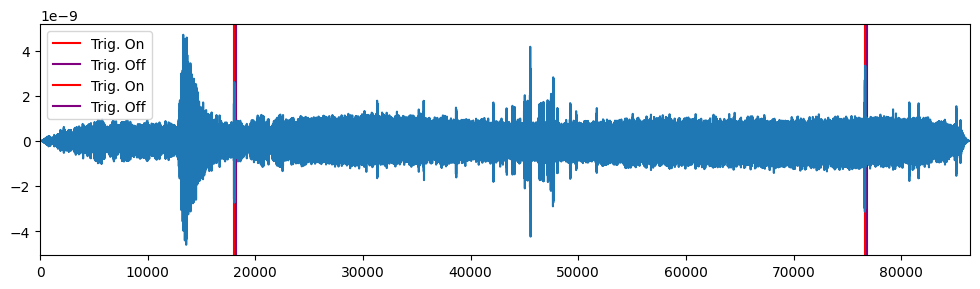

In [71]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 3
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()


In [72]:
# File name and start time of trace
fname = row.filename
starttime = tr.stats.starttime.datetime
# Iterate through detection times and compile them
detection_times = []
fnames = []

for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)

# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
detect_df.head()

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,1970-03-25T05:00:28.062642,76651.169811
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,1970-03-25T21:17:31.609811,76651.169811


# Analyze now Mars Data

In [88]:
first_mseed_file_path = r'..\data\mars\training\data\XB.ELYSE.02.BHV.2022-01-02HR04_evid0005.mseed'
st = read(mseed_file)

In [89]:
st[0].stats

         network: XB
         station: ELYSE
        location: 02
         channel: BHV
       starttime: 2022-01-02T04:00:00.025000Z
         endtime: 2022-01-02T04:59:59.975000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 72000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 143, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 585728})

In [90]:
bhu = st.select(channel="BHU")
bhv = st.select(channel="BHV")
bhw = st.select(channel="BHW")

In [103]:
print(f"BHW: {bhw}")
print(f"BHU: {bhu}")
print(f"BHV: {bhv}")

BHW: 0 Trace(s) in Stream:

BHU: 0 Trace(s) in Stream:

BHV: 1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-01-02T04:00:00.025000Z - 2022-01-02T04:59:59.975000Z | 20.0 Hz, 72000 samples


In [107]:
first_mseed_file_path = r'D:\Projects\NASA SpaceApps\xb.elyse.67.mhw.mqs2019drgb.1.mseed'
st = read(mseed_file)

In [108]:
bhu = st.select(channel="BHU")
bhv = st.select(channel="BHV")
bhw = st.select(channel="BHW")

In [109]:
print(f"BHW: {bhw}")
print(f"BHU: {bhu}")
print(f"BHV: {bhv}")

BHW: 0 Trace(s) in Stream:

BHU: 0 Trace(s) in Stream:

BHV: 1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-01-02T04:00:00.025000Z - 2022-01-02T04:59:59.975000Z | 20.0 Hz, 72000 samples


# Exploring again all data

In [110]:
cat_directory_lunar = '../data/lunar/training/catalogs/'
cat_file = cat_directory_lunar + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat


,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [115]:
lunar_file_name = cat.iloc[:,0].values
lunar_file_name

array(['xa.s12.00.mhz.1970-01-19HR00_evid00002',
       'xa.s12.00.mhz.1970-03-25HR00_evid00003',
       'xa.s12.00.mhz.1970-03-26HR00_evid00004',
       'xa.s12.00.mhz.1970-04-25HR00_evid00006',
       'xa.s12.00.mhz.1970-04-26HR00_evid00007',
       'xa.s12.00.mhz.1970-06-15HR00_evid00008',
       'xa.s12.00.mhz.1970-06-26HR00_evid00009',
       'xa.s12.00.mhz.1970-07-20HR00_evid00010',
       'xa.s12.00.mhz.1970-07-20HR00_evid00011',
       'xa.s12.00.mhz.1970-09-26HR00_evid00013',
       'xa.s12.00.mhz.1970-10-24HR00_evid00014',
       'xa.s12.00.mhz.1970-11-12HR00_evid00015',
       'xa.s12.00.mhz.1970-12-11HR00_evid00017',
       'xa.s12.00.mhz.1970-12-27HR00_evid00019',
       'xa.s12.00.mhz.1970-12-31HR00_evid00021',
       'xa.s12.00.mhz.1971-01-15HR00_evid00022',
       'xa.s12.00.mhz.1971-01-28HR00_evid00023',
       'xa.s12.00.mhz.1971-01-29HR00_evid00024',
       'xa.s12.00.mhz.1971-02-09HR00_evid00026',
       'xa.s12.00.mhz.1971-03-25HR00_evid00028',
       'xa.s12.00.mh

In [116]:
data_directory = '../data/lunar/training/data/S12_GradeA/'
mseed_first_file = f'{data_directory}{lunar_file_name[0]}.mseed'

In [117]:
mseed_first_file

'../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed'

In [121]:
st = read(mseed_first_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-01-19T00:00:00.665000Z - 1970-01-20T00:00:02.778208Z | 6.6 Hz, 572415 samples

In [123]:
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-01-19T00:00:00.665000Z
         endtime: 1970-01-20T00:00:02.778208Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572415
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [130]:
import obspy
import pandas as pd

def extract_stats(file_name):
    """Extracts statistical data from an mseed file.

    Args:
        file_name (str): The name of the mseed file.

    Returns:
        dict: A dictionary containing the extracted statistical data.
    """

    # Load the mseed file using obspy
    st = obspy.read(file_name)

    # Extract the desired statistical data
    stats = {
        "mseed_file_name": os.path.basename(file_name),
        "starttime": st[0].stats.starttime,
        "endtime": st[0].stats.endtime,
        "sampling_rate": st[0].stats.sampling_rate,
        "delta": st[0].stats.delta,
        "npts": st[0].stats.npts,
        "channel": st[0].stats.channel
    }

    return stats

In [131]:
# Create an empty list to store the extracted data
data = []

# Iterate over the file names and extract the stats
for file_name in lunar_file_name:
    mseed_full_path = f'{data_directory}{file_name}.mseed'
    try:
        stats = extract_stats(mseed_full_path)
        data.append(stats)
    except FileNotFoundError:
        pass
    

# Create a pandas DataFrame from the extracted data
mseed_all_files_info_dataframe = pd.DataFrame(data)


In [136]:
mseed_all_files_info_dataframe.head(50)

,mseed_file_name,starttime,endtime,sampling_rate,delta,npts,channel
0,xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed,1970-01-19T00:00:00.665000Z,1970-01-20T00:00:02.778208Z,6.625,0.150943,572415,MHZ
1,xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed,1970-03-25T00:00:00.440000Z,1970-03-26T00:00:01.949434Z,6.625,0.150943,572411,MHZ
2,xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed,1970-03-26T00:00:00.565000Z,1970-03-27T00:00:02.074434Z,6.625,0.150943,572411,MHZ
3,xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed,1970-04-25T00:00:00.196000Z,1970-04-26T00:00:02.309208Z,6.625,0.150943,572415,MHZ
4,xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed,1970-04-26T00:00:00.660000Z,1970-04-27T00:00:02.169434Z,6.625,0.150943,572411,MHZ
5,xa.s12.00.mhz.1970-06-15HR00_evid00008.mseed,1970-06-15T00:00:00.510000Z,1970-06-16T00:00:03.076038Z,6.625,0.150943,572418,MHZ
6,xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed,1970-06-26T00:00:00.116000Z,1970-06-27T00:00:03.436755Z,6.625,0.150943,572423,MHZ
7,xa.s12.00.mhz.1970-07-20HR00_evid00010.mseed,1970-07-20T00:00:00.487000Z,1970-07-21T00:00:01.996434Z,6.625,0.150943,572411,MHZ
8,xa.s12.00.mhz.1970-07-20HR00_evid00011.mseed,1970-07-20T00:00:00.487000Z,1970-07-21T00:00:01.996434Z,6.625,0.150943,572411,MHZ
9,xa.s12.00.mhz.1970-09-26HR00_evid00013.mseed,1970-09-26T00:00:00.149000Z,1970-09-27T00:00:03.469755Z,6.625,0.150943,572423,MHZ


All data from the Mars have the same variation and sampling method. We tested if the data could be from different sources, different frequencies or scaling. But in the end we found out that the data is the same in all mseed files. 

Now, we will analyze if data from Mars have also the  same consistency 

In [145]:
cat_file = r'..\data\mars\training\catalogs\Mars_InSight_training_catalog_final.csv'
cat = pd.read_csv(cat_file)

In [146]:
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:08:27.000000,507.0,evid0005
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,2022-01-02T04:35:30.000000,2130.0,evid0006


In [152]:
mars_mseed_file_names = [file_name.replace(".csv", ".mseed") for file_name in cat["filename"].values]

In [171]:
data_directory_mars_path = r"..\data\mars\training\data"

In [180]:
# Create an empty list to store the extracted data
data = []

# Iterate over the file names and extract the stats
for file_name in mars_mseed_file_names:
    mseed_full_path = os.path.join(data_directory_mars_path, file_name)
    try:
        stats = extract_stats(mseed_full_path)
        data.append(stats)
    except FileNotFoundError:
        pass
    

# Create a pandas DataFrame from the extracted data
mseed_mars_info_dataframe = pd.DataFrame(data)

In [183]:
mseed_mars_info_dataframe

,mseed_file_name,starttime,endtime,sampling_rate,delta,npts,channel
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed,2022-02-03T08:00:00.009000Z,2022-02-03T08:59:59.959000Z,20.0,0.05,72000,BHV
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed,2022-01-02T04:00:00.025000Z,2022-01-02T04:59:59.975000Z,20.0,0.05,72000,BHV
